# Implementing self-attention

We're going to trace through the implementation of a language model based on self-attention, i.e., a Transformer. Outline:

1. Tokenization (we'll use character-level)
2. Token embeddings
3. A single MLP network (which will only be able to look at one token at a time)
4. Self-attention

You'll be given implementations of basically everything; your task will be to *trace through* the code and understand how it works. The code is written in PyTorch, but you won't need to know PyTorch to understand it.

## Setup

In [1]:
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def num_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

if False:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" # with so much overhead in this implementation, GPU doesn't help us much.

# Dataset

We'll use the [TinyStories](https://huggingface.co/datasets/roneneldan/TinyStories) dataset, which is a collection of short stories generated by OpenAI's GPT-3.5. (So don't expect amazing storytelling here.) We'll train the model to predict the next character in the story.

First, we'll take a subset of the dataset for training and validation.

In [3]:
from datasets import load_dataset

dataset = load_dataset("roneneldan/TinyStories", split="train[:5000]")

# make a tiny dataset for experimentation
split_datasets = dataset.train_test_split(test_size=1000, shuffle=False)
train_ds = split_datasets['train']
test_ds = split_datasets['test']
train_ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 4000
})

In [4]:
# show an example
example = train_ds[1]
print("Example story:")
print(example['text'])

Example story:
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were falling. Beep liked how the leaves fall and wanted to play with them. Beep drove under the tree and watched the leaves fall on him. He laughed and beeped his horn.

Beep played with the falling leaves all day. When it was time to go home, Beep knew he needed more fuel. He went to the fuel place and got more healthy fuel. Now, Beep was ready to go fast and play again the next day. And Beep lived happily ever after.


# Tokenization

To turn strings into numbers, we'll use the Unicode code point for each character. (To keep things simple, we won't batch anything.)

You don't need to read or understand the code in this section; just run it and look at the results.

In [5]:
n_vocab = 256

def encode_doc(doc):
    token_ids = torch.tensor([ord(x) for x in doc], device=device)
    # Remove any tokens that are out-of-vocabulary
    token_ids = token_ids[token_ids < n_vocab]
    return token_ids

sentence_tensor = encode_doc(example['text'][:50]).cpu() # keep it on CPU for now
sentence_tensor

tensor([ 79, 110,  99, 101,  32, 117, 112, 111, 110,  32,  97,  32, 116, 105,
        109, 101,  44,  32, 116, 104, 101, 114, 101,  32, 119,  97, 115,  32,
         97,  32, 108, 105, 116, 116, 108, 101,  32,  99,  97, 114,  32, 110,
         97, 109, 101, 100,  32,  66, 101, 101])

In [6]:
def decode(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()
    return ''.join(chr(x) for x in x)
decode(sentence_tensor)

'Once upon a time, there was a little car named Bee'

In [7]:
# tokenize the dataset
def tokenize_function(examples):
    return dict(
        input_ids=encode_doc(examples["text"])
    )

train_tokenized = train_ds.map(tokenize_function)
train_tokenized.set_format(type='torch', columns=['input_ids'], device=device)

# Each item is now a dictionary with a single key 'input_ids' containing the tokenized text.
example = train_tokenized[1]
example['input_ids'][:10]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

tensor([ 79, 110,  99, 101,  32, 117, 112, 111, 110,  32])

In [8]:
print(decode(example['input_ids']))

Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were falling. Beep liked how the leaves fall and wanted to play with them. Beep drove under the tree and watched the leaves fall on him. He laughed and beeped his horn.

Beep played with the falling leaves all day. When it was time to go home, Beep knew he needed more fuel. He went to the fuel place and got more healthy fuel. Now, Beep was ready to go fast and play again the next day. And Beep lived happily ever after.


## Multi-Layer Perceptron

One of the building blocks of our language model will be a MLP that we looked at in previous notebooks. It will take an input (in "embedding dimension", which we'll define shortly), project it to a hidden space (typically 4 times as wide as the embedding dimension), apply a nonlinearity like ReLU, then project back to the same dimensionality as the input.

Fill in the blanks below to define an MLP as a PyTorch `Module`.

In [9]:
class MLP(nn.Module):
    def __init__(self, emb_dim, n_hidden):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=emb_dim, out_features=n_hidden),
            nn.ReLU(), # or nn.GELU() or others
            nn.Linear(in_features=n_hidden, out_features=emb_dim)
            # The full Transformer adds some dropout here.
        )

    def forward(self, x):
        return self.model(x)


# A language model with a single MLP

Before we get to the Transformer, we'll start with a simple model that can only look at one token at a time.

At both the input and output of the model, we'll need to translate between the model's internal representation (a vector) and the actual characters. To do this we use *token embeddings*.

We'll use a vocabulary size of 256 (very small, but enough to store individual *bytes*) and an embedding dimensionality of 32 (also pretty small).

In [10]:
emb_dim = 32

Now we'll build this model. Skim this code, but we'll come back and delve into it more, so don't worry if you don't understand everything right away.

In [11]:
class FeedForwardLM(nn.Module):
    def __init__(self, n_vocab, emb_dim, n_hidden):
        super().__init__()
        self.word_to_embedding = nn.Embedding(n_vocab, emb_dim)
        self.model = MLP(emb_dim=emb_dim, n_hidden=n_hidden)
        self.lm_head = nn.Linear(emb_dim, n_vocab, bias=False)

        # Use the token embeddings for the LM head ("tie weights")
        assert self.lm_head.weight.shape == self.word_to_embedding.weight.shape
        self.lm_head.weight = self.word_to_embedding.weight

    def forward(self, input_ids):
        # This method gets called when we "call" the model object on some input data.
        input_embeds = self.word_to_embedding(input_ids)
        x = self.model(input_embeds)
        return self.lm_head(x)

Let's train this overly-simple model and see what it learns.

The feed-forward-only LM has 16544 parameters
Epoch 0, Loss: 2.375427825987339
Epoch 1, Loss: 2.3108096597790717
Epoch 2, Loss: 2.3061845289468765
Epoch 3, Loss: 2.3035585985183715
Epoch 4, Loss: 2.3020125875473023


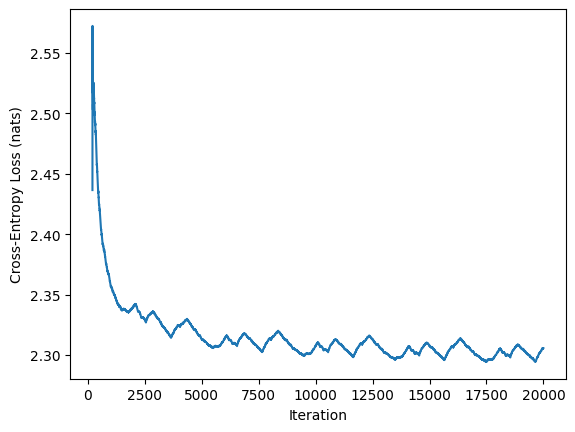

In [12]:
# Let's train the model
model = FeedForwardLM(n_vocab=n_vocab, emb_dim=emb_dim, n_hidden=emb_dim * 4)
print(f"The feed-forward-only LM has {num_parameters(model)} parameters")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

for epoch in range(5):
    sample_counter = 0
    for example in train_tokenized:
        token_ids = example['input_ids']
        assert token_ids.max() < n_vocab

        # set up a causal language modeling task:
        # each token should be predicted using the tokens before it
        input_ids = token_ids[:-1]
        targets   = token_ids[1:]

        logits = model(input_ids)
        loss = nn.CrossEntropyLoss()(logits, targets)

        # Do gradient descent and keep track of the loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        sample_counter += 1

    avg_loss_this_epoch = sum(losses[-sample_counter:]) / sample_counter
    print(f"Epoch {epoch}, Loss: {avg_loss_this_epoch}")


# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses)[200:].ewm(alpha = .001).mean().plot()
plt.xlabel('Iteration')
plt.ylabel("Cross-Entropy Loss (nats)");

## Trace the Simple Model

We'll now go through the model's forward pass, step by step, to see how it processes a single character.

In [13]:
# Look at the example again; just the first 10 tokens to keep it simple.
example = train_tokenized[1]
token_ids = example['input_ids'][:10]
print(decode(token_ids))

Once upon 


We'll make this an autoregressive language model, so our goal will be to predict the next character. So we'll need to shift the targets left, so each character should output the next one.

In [14]:
input_ids = token_ids[:-1]
targets   = token_ids[1:]
assert input_ids.shape == targets.shape

print("Inputs: ", decode(input_ids))
print("Targets:", decode(targets))

Inputs:  Once upon
Targets: nce upon 


### Step 1: Embeddings

We'll be working through the `forward` method step by step. The first step is to embed the input character. The `word_to_embedding` module is just a lookup table that maps each possible character to a (learned) 32-dimensional vector.

In [15]:
token_embedding_table = model.word_to_embedding.weight
tuple(token_embedding_table.shape)

(256, 32)

In [16]:
print("Input ids shape:", tuple(input_ids.shape))
input_embeds = model.word_to_embedding(input_ids)
print("Input embeddings shape:", tuple(input_embeds.shape))

Input ids shape: (9,)
Input embeddings shape: (9, 32)


**Pause to reflect**: Explain each number of the input embeddings shape.


- 9 represents the number of tokens in the input sequence.

- 32 represents the dimension of each embedding vector.

### Step 2: MLP

Now we pass the embedding through the MLP. First, project the inputs to the hidden layer:

In [17]:
mlp = model.model
mlp_hidden_layer = mlp.model[0](input_embeds)
print("MLP hidden layer shape:", tuple(mlp_hidden_layer.shape))
print("Min value of the hidden layer:", mlp_hidden_layer.min().item())

MLP hidden layer shape: (9, 128)
Min value of the hidden layer: -2.308556079864502


Then apply the activation function (ReLU):

In [18]:
mlp_hidden_activations = mlp.model[1](mlp_hidden_layer)
print("MLP hidden activations shape:", tuple(mlp_hidden_activations.shape))
print("Min value of the activations:", mlp_hidden_activations.min().item())

MLP hidden activations shape: (9, 128)
Min value of the activations: 0.0


Then project back to the embedding dimension:

In [19]:
mlp_output = mlp.model[2](mlp_hidden_activations)
print("MLP output shape:", tuple(mlp_output.shape))

MLP output shape: (9, 32)


### Step 3: LM Head

The MLP outputs are now the context embeddings. To turn them into predictions for the next character, we'll pass them through the LM head (which is just a linear layer):

In [20]:
lm_head = model.lm_head
lm_logits = lm_head(mlp_output)

# Since the weights are tied, this is the same thing as mlp_output @ token_embedding_table.T

Now we have our logits. **Pause to reflect**: What is the shape of the logits tensor? What does each number represent?

In [21]:
lm_logits.shape



torch.Size([9, 256])

- 9: The number of input tokens in the sequence.
- 256: This is the size of the vocabulary.

What did each of the 9 tokens predict as the next character?

In [22]:
for i in range(len(input_ids)):
    print(f"Token: {decode(input_ids[i:i+1])}; Most likely next token:", decode([lm_logits[i].argmax()]))

Token: O; Most likely next token: n
Token: n; Most likely next token: d
Token: c; Most likely next token: a
Token: e; Most likely next token:  
Token:  ; Most likely next token: t
Token: u; Most likely next token: t
Token: p; Most likely next token: l
Token: o; Most likely next token:  
Token: n; Most likely next token: d


Here's how we compute the cross-entropy loss between the predicted and actual next characters. (In PyTorch, the `CrossEntropyLoss` function combines the softmax and the negative log likelihood loss, i.e., it expects to be given *logits*, not probabilities.)

In [23]:
loss = nn.CrossEntropyLoss()(lm_logits, targets)
loss

tensor(2.1486, grad_fn=<NllLossBackward0>)

## Generating text

To see what the model learned, we'll try generating some text.

In [24]:
prompt = 'A'
prompt_tensor = encode_doc(prompt)
prompt_tensor

tensor([65])

Fill in the blanks below to implement temperature sampling for this model.

Let's try sampling generation.

In [25]:
prompt_tensor = encode_doc('A')
temperature = 0.5
for i in range(100):
    logits = model(prompt_tensor)
    # Get the next-token logits
    next_token_logits = logits[-1]
    # Scale the logits by the temperature
    scaled_logits = next_token_logits / temperature
    # Apply softmax to get probabilities
    probs = scaled_logits.softmax(dim=-1)
    # sample from the probability distribution
    next_token = torch.multinomial(probs, num_samples=1)
    # append the token to the prompt tensor
    prompt_tensor = torch.cat([prompt_tensor, next_token])

# Show the generated text
print(decode(prompt_tensor))

And t t thinthe t go tet Lime he and s the s fus he ane it way s toutome wand t to s. ar an t her Tis


## Self-Attention

To make better predictions, we'll need to let the model look at more than just one token at a time. We'll do this with *self-attention*. The idea is that each token can look at all the other tokens and decide how much to pay attention to each one. This is a powerful mechanism that allows the model to learn dependencies between tokens that are far apart. (For example, in the sentence "I grew up in France... I speak fluent French", the word "French" is highly dependent on the word "France", but they're far apart in the sentence.)

In the last year, billions of computing dollars have been spent on training and running models that are basically just stacks of self-attention layers like what we'll implement in this section. It's a very powerful idea! (It even made the predictions that I accepted to type in more than half of the words in the previous paragraph, haha!)

We're going to implement an oversimplified Self-Attention layer. If you're interested, here are a few reference implementations of the real thing:

- https://github.com/jaymody/picoGPT/ (ridiculously compact)
- [minGPT](https://github.com/karpathy/minGPT/blob/master/mingpt/model.py) (more readable)
- https://github.com/karpathy/nanoGPT/blob/master/model.py (more brrr)
- [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- PyTorch's builtin implementation: [`TransformerEncoderLayer`](https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#TransformerEncoderLayer) and [`MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention).

We'll start with a big pile of code, then pull it apart step by step. So *run this code first*, then we'll come back to try to understand it. (It'll take a bit longer to train, too, so get the training cell started while you read the code.)

In [26]:
VERY_SMALL_NUMBER = -1e9
def make_causal_mask(sequence_len):
    return (1 - torch.tril(torch.ones(sequence_len, sequence_len))) * VERY_SMALL_NUMBER

class BareBonesAttentionHead(nn.Module):
    '''Implements *single-head* attention, no dropout, no init'''
    def __init__(self, emb_dim, head_dim):
        super().__init__()
        self.head_dim = head_dim
        self.get_query = nn.Linear(emb_dim, head_dim, bias=False)
        self.get_key = nn.Linear(emb_dim, head_dim, bias=False)
        self.get_value = nn.Linear(emb_dim, head_dim, bias=False)

    def forward(self, x):
        seq_len, emb_dim = x.shape

        # Compute query, key, and value vectors.
        q = self.get_query(x) # (seq_len, head_dim)
        k = self.get_key(x)
        v = self.get_value(x)

        # Compute attention weights.
        k_transpose = k.transpose(-2, -1)
        assert k_transpose.shape == (self.head_dim, seq_len)
        scores = q @ k_transpose  / emb_dim**0.5
        assert scores.shape == (seq_len, seq_len)
        # Apply the causal mask
        causal_mask = make_causal_mask(seq_len).to(scores.device)
        scores = scores + causal_mask
        attention_weights = scores.softmax(dim=-1)
        # The full Transformer adds some dropout here.

        # Compute weighted sum of values.
        out = attention_weights @ v
        return out

class BareBonesSelfAttention(nn.Module):
    def __init__(self, emb_dim, head_dim, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([
            BareBonesAttentionHead(emb_dim, head_dim)
            for i in range(n_heads)
        ]) # we need a ModuleList to make sure the heads are counted as children.
        # This last linear layer projects concatenated embeddings back to the original embedding space.
        # It's not strictly necessary; you could premultiply it with the get_value matrices.
        self.to_output = nn.Linear(n_heads * head_dim, emb_dim, bias=False)

    def forward(self, x):
        head_outputs = [head(x) for head in self.heads]
        concats = torch.cat(head_outputs, dim=-1)
        out = self.to_output(concats)
        assert out.shape == x.shape
        return out


Now we'll define a Transformer. Well, we'll just define a single layer. A true Transformer will have many (perhaps 32, 64, 118, ...) such layers. But it's just running a bunch of instances of a layer like this in sequence.

One new thing here is the *layer norm*. It basically rescales the activations to be mean 0 variance 1, then scales and shifts by learnable constants. So each one adds 2 * emb_dim parameters to the model, and there's one after each part (self-attention and MLP).

In [27]:
class BareBonesTransformerLayer(nn.Module):
    '''Implements bare-bones self-attention transformer layer, no residual connections, no dropout'''
    def __init__(self, emb_dim, head_dim, n_heads, dim_feedforward):
        super().__init__()
        self.self_attention = BareBonesSelfAttention(emb_dim, head_dim=head_dim, n_heads=n_heads)
        self.mlp = MLP(emb_dim, n_hidden=dim_feedforward)
        self.norm_1 = nn.LayerNorm(emb_dim)
        self.norm_2 = nn.LayerNorm(emb_dim)

    def forward(self, x):
        x = x + self.self_attention(self.norm_1(x))
        x = x + self.mlp(self.norm_2(x))
        return x

xformer_layer = BareBonesTransformerLayer(emb_dim, dim_feedforward=emb_dim, head_dim=256, n_heads=2)

Now, at long last, let's make a complete Transformer-based language model.

A big new aspect here is the *position embeddings*. We'll implement *learned absolute position embeddings*, which do add parameters to the model. (A cool new approach, called *Rotary Position Embeddings* ([RoPE](https://blog.eleuther.ai/rotary-embeddings/)), gets comparable or better performance without adding parameters; most current models, like Llama2 and Gemma, use it.)

In [28]:
max_len = 100

class TransformerLM(nn.Module):
    def __init__(self, n_vocab, max_len, emb_dim, n_hidden, head_dim=5, n_heads=4):
        super().__init__()
        self.word_to_embedding = nn.Embedding(n_vocab, emb_dim)
        self.pos_to_embedding = nn.Embedding(max_len, emb_dim)
        self.model = BareBonesTransformerLayer(
            emb_dim=emb_dim, dim_feedforward=n_hidden,
            head_dim=head_dim, n_heads=n_heads)
        self.lm_head = nn.Linear(emb_dim, n_vocab, bias=False)

        assert self.lm_head.weight.shape == self.word_to_embedding.weight.shape
        self.lm_head.weight = self.word_to_embedding.weight

    def forward(self, input_ids):
        seq_len = input_ids.shape[-1]
        if seq_len > max_len:
            # Fail if the input sequence is too long.
            raise ValueError(f"Input sequence length {seq_len} is longer than the maximum of {max_len}")
        input_embeds = self.word_to_embedding(input_ids)
        # Compute position embeddings.
        position_ids = torch.arange(seq_len, device=input_ids.device)
        pos_embeds = self.pos_to_embedding(position_ids)
        x = input_embeds + pos_embeds
        x = self.model(x)
        return self.lm_head(x)

### Train the Transformer

Now let's try training that model. Run this code, it'll take a minute or two.

Epoch 0, Loss: 2.6746543630957604
Epoch 1, Loss: 1.8772605989575386
Epoch 2, Loss: 1.7941548792272806
Epoch 3, Loss: 1.7267352709323167
Epoch 4, Loss: 1.6458295021653175


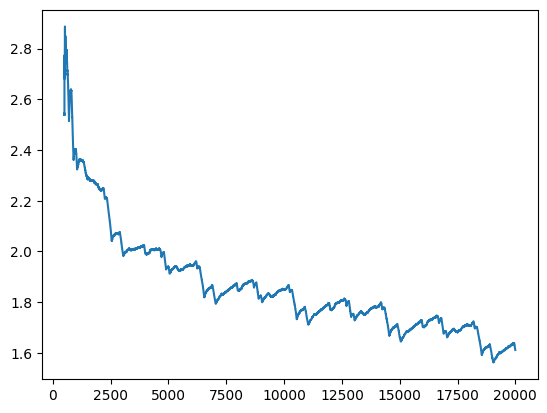

In [49]:
# Set up a single-head model so it's easier to trace. Later you can try more heads.
model = TransformerLM(n_vocab=n_vocab, max_len=max_len, emb_dim=emb_dim, n_hidden=emb_dim * 4, head_dim=emb_dim // 2, n_heads=1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

for epoch in range(5):
    sample_counter = 0
    for example in train_tokenized:
        # Truncate the example to the context length of the model.
        token_ids = example['input_ids'][:max_len]
        input_ids = token_ids[:-1]
        targets = token_ids[1:]

        assert token_ids.max() < n_vocab

        logits = model(input_ids)
        loss = nn.CrossEntropyLoss()(logits, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        sample_counter += 1
    avg_loss_this_epoch = sum(losses[-sample_counter:]) / sample_counter
    print(f"Epoch {epoch}, Loss: {avg_loss_this_epoch}")

# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses)[500:].ewm(alpha = .001).mean().plot();

Notice that the loss values are much lower than the simple feed-forward model; that's one clue that this model is capturing a lot more of the patterns of how characters are related to each other. Another way we'll see how much better this is is by generating text.

Try a few different prompts here to start the story, like  "once" or "One" to start the story. Use a moderate temperature, like 0.3 or 0.5.

**Note**: The model is trained on a tiny dataset, so it won't be able to generate coherent stories. But it should be able to do much better than the one-character-at-a-time model. If we wanted to do better, the easiest thing is to increase the number of attention heads, and train on more data for longer.

In [50]:
prompt_tensor = encode_doc('Once')
temperature = 0.5
for i in range(30):
    logits = model(prompt_tensor)
    probs = (logits[-1] / temperature).softmax(dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    prompt_tensor = torch.cat([prompt_tensor, next_token])
decode(prompt_tensor)

'Once upon a time, there was a litt'

### Tracing the Transformer

Just like we did above with the simple model, let's trace through the Transformer's forward pass.

You might find it helpful to have the preview of this notebook open in another window so you can follow the code for the forward pass.

As before, we first compute the embeddings for the input tokens:

In [51]:
prompt_tensor = encode_doc('Once')
input_embeds = model.word_to_embedding(prompt_tensor)
print("Input embeddings shape:", tuple(input_embeds.shape))


Input embeddings shape: (4, 32)


Now we *add the position embeddings*. This lets the model know where each token is. This is a simple learned embedding, so we just look up the position embedding for each token and add it to the token's embedding:

In [52]:
seq_len = prompt_tensor.shape[-1]
position_ids = torch.arange(seq_len)
position_ids

tensor([0, 1, 2, 3])

In [53]:
pos_embeds = model.pos_to_embedding(position_ids)
x = input_embeds + pos_embeds
print("Input embeddings shape:", tuple(x.shape))

Input embeddings shape: (4, 32)


Next we go through a layer normalization. It basically just rescales its inputs; we won't dwell on it here.

In [54]:
x = model.model.norm_1(x)
print("Normalized input embeddings shape:", tuple(x.shape))

Normalized input embeddings shape: (4, 32)


Now the interesting part: a self-attention layer. In general a self-attention layer can have multiple "heads", but we just have one here. We'll go through it step by step.

In [55]:
head = model.model.self_attention.heads[0]

An attention head computes three things for each token: a **query** (q), which then gets compared with all of the **key**s (k), and for those that match, we add up the **value**s (v). Let's do that. The query, key, and value are all computed by multiplying the input by learned weight matrices.

In [56]:
head.get_query

Linear(in_features=32, out_features=16, bias=False)

When we do a forward pass, we compute q, k, and v for each token. We do that by passing the input embeddings through those linear layers.

In [57]:
queries = head.get_query(x)
keys = head.get_key(x)
values = head.get_value(x)

**Stop**: What shape will `queries` have? What about `keys` and `values`? Check your answers by printing them out.

I think the shape that they will have is all the same which is (4, 16)

In [58]:
print("Queries shape:", tuple(queries.shape))
print("Keys shape:", tuple(keys.shape))
print("Values shape:", tuple(values.shape))

Queries shape: (4, 16)
Keys shape: (4, 16)
Values shape: (4, 16)


Now, let's compute how how much each token's query matches each token's key. We do that by computing the dot product of each query with each key. We could do something like:

In [59]:
query_2_key_1 = queries[2] @ keys[1]

But that would be tedious and require looping. Instead, we can just compute a matrix multiplication.

In [60]:
query_key_products = queries @ keys.T
query_key_products.shape

torch.Size([4, 4])

In [61]:
# Check that it's computing the same thing.
assert torch.allclose(query_2_key_1, query_key_products[2, 1])

The result is a matrix of dot products. Let's look at it. (Note: since the model was initialized randomly, your values will be different.)

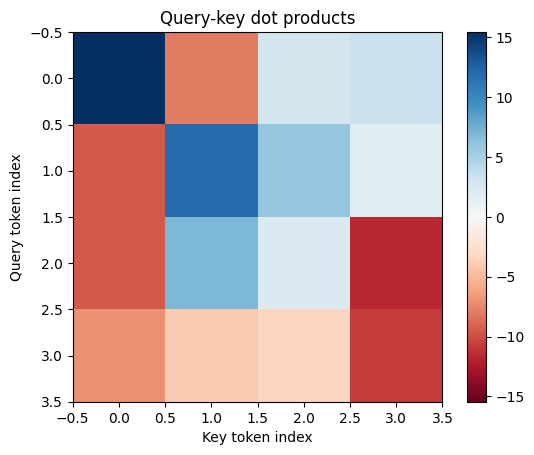

In [62]:
# center the color scale on 0.
max_values = torch.abs(query_key_products).max().item()
plt.imshow(query_key_products.detach().numpy(), cmap="RdBu", vmin=-max_values, vmax=max_values)
plt.title("Query-key dot products")
plt.xlabel("Key token index")
plt.ylabel("Query token index")
plt.colorbar();

We then use the softmax function to compute how much to actually pay attention to each token. It turns out that to stabilize the computation, it helps to use a temperature proportional to the square root of the dimensionality of the keys.

In [63]:
attention_weights = F.softmax(query_key_products / emb_dim**0.5, dim=-1)

What do the attention weights look like?

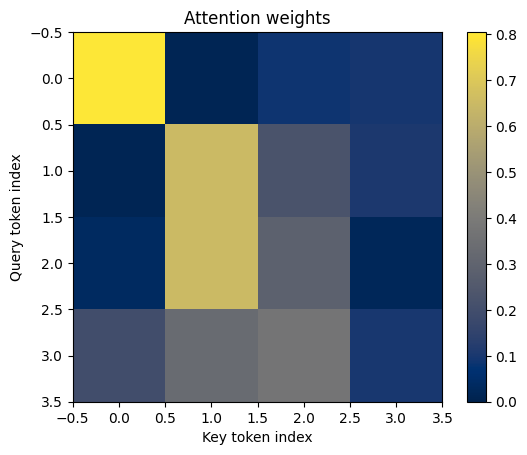

In [64]:
plt.imshow(attention_weights.detach().numpy(), cmap="cividis", vmin=0)
plt.title("Attention weights")
plt.xlabel("Key token index")
plt.ylabel("Query token index")
plt.colorbar();

Those weights determine, for each token, how much of each other token's `value` to add up. We can compute that by multiplying the weights by the values.

In [65]:
first_token_output = attention_weights[0] @ values
first_token_output.shape

torch.Size([16])

Again, we can do the computation all at once by computing a matrix multiplication.

In [66]:
head_output = attention_weights @ values
assert torch.allclose(first_token_output, head_output[0])

The full attention mechanism has this go through another linear layer, but we'll skip that for now.

**But wait!** Tokens shouldn't be able to attend to tokens that come after them. We need to **mask out the attention weights** for tokens after the current one.

A simple way to do that is to set the dot products to a very small value for tokens that come after the current token. That way, when we apply the softmax, the attention weights will be very close to zero.

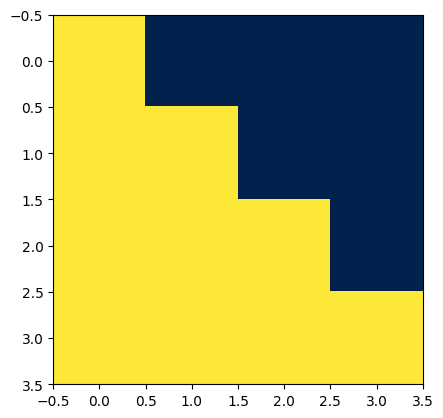

In [67]:
sequence_len = x.shape[0]
causal_mask = make_causal_mask(sequence_len)
plt.imshow(causal_mask.detach().numpy(), cmap="cividis", vmin=-1e9);

To apply the so-called "causal mask", we can just add it to the dot products before applying the softmax.

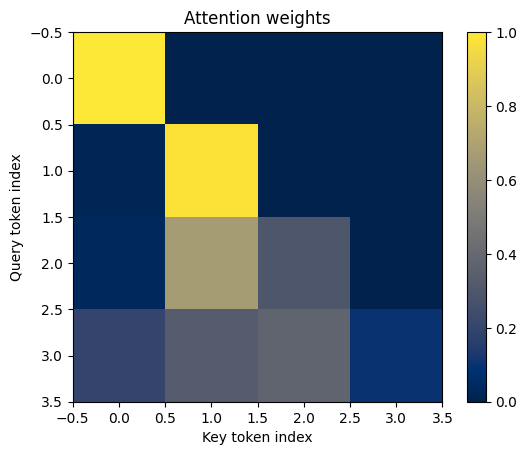

In [68]:
attention_weights = F.softmax((query_key_products + causal_mask) / emb_dim**0.5, dim=-1)
plt.imshow(attention_weights.detach().numpy(), cmap="cividis", vmin=0)
plt.title("Attention weights")
plt.xlabel("Key token index")
plt.ylabel("Query token index")
plt.colorbar();

### Finish the trace

We just looked at the self-attention part of the Transformer. *Finish the trace* by going through the rest of the forward pass until you get the logits. (Refer to the code above to see the rest of the forward pass.)

At each step, write what the *shape* of the tensor is, and what it represents.

In [72]:
# Normalization Layer
head_output = model.model.self_attention(x)
x = x + head_output
x = model.model.norm_1(x)
print(tuple(x.shape))

(4, 32)


The shape represent output after applying layer normalization to the output of the self-attention mechanism in the transformer layer. 4 represent a token  in the input sequence, and  32 represents the embedding dimension.

In [73]:
# MLP
x = model.model.mlp(x)
print(tuple(x.shape))


(4, 32)


The shape represent the output after passing MLP in the transformer layer. 4 represent a token in the input sequence, and 32 represents the embedding dimension

In [74]:
# Second Normalization Layer
x = x + model.model.norm_2(x)
print(tuple(x.shape))

(4, 32)


The shape for this step represent the output after applying layer normalization to the output of the MLP in the transformer layer where 4 represent a token in the input sequence, and 32 represents the embedding dimension.

In [75]:
# LM head Logits
logits = model.lm_head(x)
print(tuple(logits.shape))

(4, 256)


The shape for logits represent the next token prediction generated by passing the output of the second normalization layer through the language model head. 4 represents the token in the input sequence, and 256 represents the probability distribution over the vocabulary for the next token.